In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [3]:
from helpers_thresholds import *

In [4]:
plt.rcParams['figure.figsize'] = (12,6)
font = {'family' : 'DejaVu Sans',  'weight' : 'normal',  'size'  : 40}
plt.rc('font', **font)

In [5]:
tensor_transform = get_tensor_transform('ImageNet', False)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform(16)
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
# df_train = get_df(df, 20, True, False, False)
# class_image_paths, end_idx, idx_label= get_indices(df_train, root_dir)
# train_loader = get_loader(1, 128, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, False, True, True, 1)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx, idx_label = get_indices(df_valid, root_dir)
valid_loader = get_loader(20, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False, True, 1)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx, idx_label = get_indices(df_test, root_dir)
test_loader = get_loader(20, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False, True, 1)

torch.cuda.empty_cache()

In [6]:
load = True
if load:
    checkpoint = torch.load('/media/scratch/astamoulakatos/saved-resnet-models/fifth-small-aug-final/best-checkpoint-010epoch.pth')
    resnet.load_state_dict(checkpoint['model_state_dict'])
    print('loading pretrained freezed model!')

loading pretrained freezed model!


In [7]:
inputs, classes = next(iter(valid_loader))

In [8]:
inputs.shape

torch.Size([1, 3, 16, 576, 704])

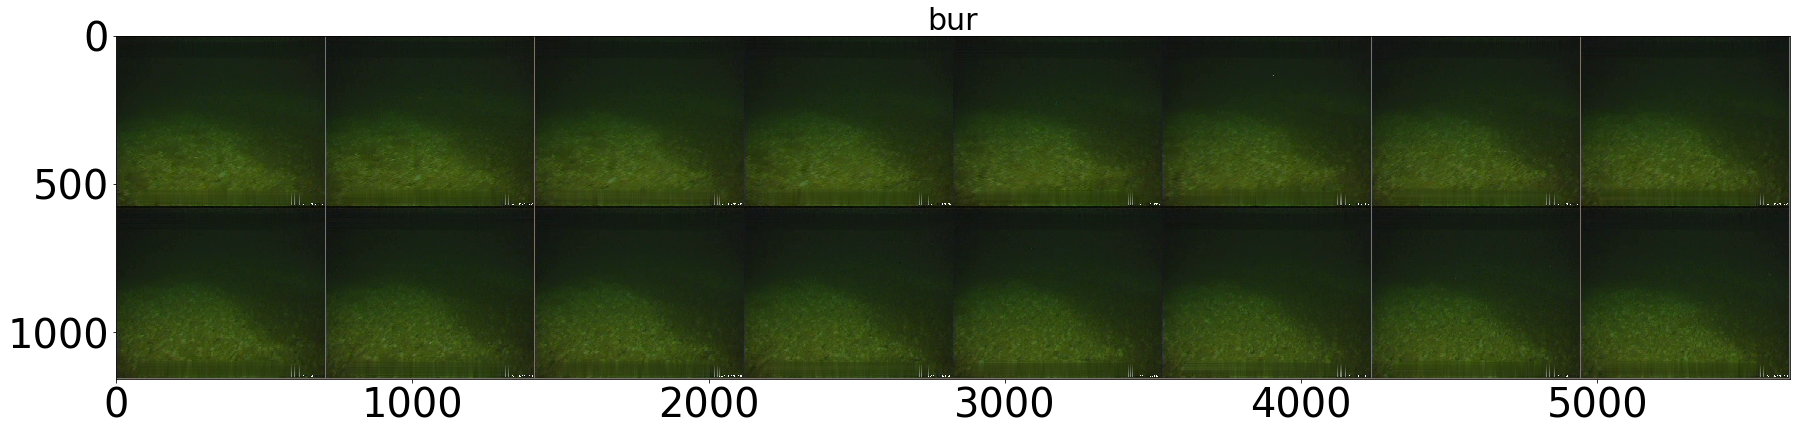

In [10]:
show_batch(valid_loader, 1)

In [12]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu().numpy()
        cl1 = []
        cl2 = []
        cl3 = []
        cl4 = []
        cl5 = []
        for p in preds:
            cl1.append(p[0])
            cl2.append(p[1])
            cl3.append(p[2])
            cl4.append(p[3])
            cl5.append(p[4])

        rolling_preds[0]=np.mean(cl1)
        rolling_preds[1]=np.mean(cl2)
        rolling_preds[2]=np.mean(cl3)
        rolling_preds[3]=np.mean(cl4)
        rolling_preds[4]=np.mean(cl5)
        
        y_pred.append(rolling_preds)
        y_true.append(y.detach().cpu().numpy())
        
#         if (np.mean(cl1) > 0.5):
#             rolling_preds[0] = 1
#         else:
#             rolling_preds[0] = 0

#         if (np.mean(cl2) > 0.5):
#             rolling_preds[1] = 1
#         else:
#             rolling_preds[1] = 0   

#         if (np.mean(cl3) > 0.5):
#             rolling_preds[2] = 1
#         else:
#             rolling_preds[2] = 0

#         if (np.mean(cl4) > 0.5):
#             rolling_preds[3] = 1
#         else:
#             rolling_preds[3] = 0 

#         if (np.mean(cl5) > 0.5):
#             rolling_preds[4] = 1
#         else:
#             rolling_preds[4] = 0        

        #running_acc += accuracy_score(y.detach().cpu().numpy(), rolling_preds) *  X.size(0)
        #running_f1 += f1_score(y.detach().cpu().numpy(), (rolling_preds), average="samples")  *  X.size(0)

# epoch_acc = running_acc / len(valid_loader.dataset)
# epoch_f1 = running_f1 / len(valid_loader.dataset)

# valid_result.append('Validation Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, epoch_f1))
# print(valid_result)

In [ ]:
from helpers_thresholds import *

In [ ]:
rolling_preds

In [ ]:
y_true

In [ ]:
y_pred

In [ ]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

In [ ]:
plot_pr_curves(0.0, y_tr, y_pr, classes, '_2d_rolling_avg')

In [ ]:
thresholds = nsea_compute_thresholds(y_true, y_pred, classes)

In [ ]:
thresholds

In [20]:
df_thresholds = pd.DataFrame({'Threshold': thresholds}).T
df_thresholds

,Anode,Burial,Exposure,Field Joint,Free Span
Threshold,0.368274,0.153043,0.711437,0.1474,0.396851


# Table 1

In [21]:
print(df_thresholds.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{lrrrrr}
\toprule
{} &  Anode &  Burial &  Exposure &  Field Joint &  Free Span \\
\midrule
Threshold &  0.368 &   0.153 &     0.711 &        0.147 &      0.396 \\
\bottomrule
\end{tabular}



## validation set

In [22]:
result_valid = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [23]:
result_valid

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.711437,0.863101,0.923301,0.883856,0.903148,1450.0,342.0,541.0,4117.0
1,Burial,0.153043,0.863101,0.691691,0.915179,0.787893,3927.0,731.0,152.0,1640.0
2,Field Joint,0.147400,0.895039,0.622677,0.936626,0.748046,4768.0,609.0,68.0,1005.0
3,Anode,0.368274,0.942016,0.675000,0.597786,0.634051,5752.0,156.0,218.0,324.0
4,Free Span,0.396851,0.997054,0.997707,0.993607,0.995653,4255.0,5.0,14.0,2176.0
5,Aggregate,NaN,0.728837,0.822119,0.876202,0.839318,NaN,NaN,NaN,NaN


In [24]:
print(result_valid.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &       tn &      fp &      fn &       tp \\
\midrule
0 &     Exposure &      0.711 &                 0.863 &      0.923 &   0.883 &     0.903 & 1450.000 & 342.000 & 541.000 & 4117.000 \\
1 &       Burial &      0.153 &                 0.863 &      0.691 &   0.915 &     0.787 & 3927.000 & 731.000 & 152.000 & 1640.000 \\
2 &  Field Joint &      0.147 &                 0.895 &      0.622 &   0.936 &     0.748 & 4768.000 & 609.000 &  68.000 & 1005.000 \\
3 &        Anode &      0.368 &                 0.942 &      0.675 &   0.597 &     0.634 & 5752.000 & 156.000 & 218.000 &  324.000 \\
4 &    Free Span &      0.396 &                 0.997 &      0.997 &   0.993 &     0.995 & 4255.000 &   5.000 &  14.000 & 2176.000 \\
5 &    Aggregate &        nan &                 0.728 &      0.822 &   0.876 &     0.839 &      nan &     nan &     nan &      nan \\
\bottomrule
\e

In [25]:
acc, f1 = compute_label_metrics(y_tr, y_pr, 0.5, classes)

In [26]:
acc

array([0.86310078, 0.86310078, 0.89503876, 0.9420155 , 0.99705426])

In [27]:
f1

array([0.90314797, 0.78789335, 0.74804615, 0.63405088, 0.99565317])

## test set

In [ ]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu().numpy()
        cl1 = []
        cl2 = []
        cl3 = []
        cl4 = []
        cl5 = []
        for p in preds:
            cl1.append(p[0])
            cl2.append(p[1])
            cl3.append(p[2])
            cl4.append(p[3])
            cl5.append(p[4])

        if (np.mean(cl1) > 0.5):
            rolling_preds[0] = 1
        else:
            rolling_preds[0] = 0

        if (np.mean(cl2) > 0.5):
            rolling_preds[1] = 1
        else:
            rolling_preds[1] = 0   

        if (np.mean(cl3) > 0.5):
            rolling_preds[2] = 1
        else:
            rolling_preds[2] = 0

        if (np.mean(cl4) > 0.5):
            rolling_preds[3] = 1
        else:
            rolling_preds[3] = 0 

        if (np.mean(cl5) > 0.5):
            rolling_preds[4] = 1
        else:
            rolling_preds[4] = 0        

        #running_acc += accuracy_score(y.detach().cpu().numpy(), rolling_preds) *  X.size(0)
        #running_f1 += f1_score(y.detach().cpu().numpy(), (rolling_preds), average="samples")  *  X.size(0)
        y_pred.append(rolling_preds)
        y_true.append(y.detach().cpu().numpy())

# epoch_acc = running_acc / len(valid_loader.dataset)
# epoch_f1 = running_f1 / len(valid_loader.dataset)

# valid_result.append('Validation Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, epoch_f1))
# print(valid_result)

In [ ]:
y_pred

In [ ]:
y_true

In [31]:
result_test = new_compute_metrics(y_tr, y_pr, thresholds, classes)

In [32]:
result_test

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.711437,0.873284,0.898407,0.917161,0.907687,1677.0,472.0,377.0,4174.0
1,Burial,0.153043,0.860000,0.760654,0.822243,0.790250,3995.0,556.0,382.0,1767.0
2,Field Joint,0.147400,0.844030,0.488298,0.917083,0.637279,4737.0,962.0,83.0,918.0
3,Anode,0.368274,0.935522,0.688805,0.575277,0.626943,5905.0,164.0,268.0,363.0
4,Free Span,0.396851,0.995970,0.986614,1.000000,0.993262,4683.0,27.0,0.0,1990.0
5,Aggregate,NaN,0.735373,0.818731,0.874179,0.836771,NaN,NaN,NaN,NaN


In [33]:
print(result_test.to_latex(float_format=lambda x: '%.3f' % truncate_decimals(x,3)))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &        Event &  Threshold &  Exact Matching Score &  Precision &  Recall &  F1-Score &       tn &      fp &      fn &       tp \\
\midrule
0 &     Exposure &      0.711 &                 0.873 &      0.898 &   0.917 &     0.907 & 1677.000 & 472.000 & 377.000 & 4174.000 \\
1 &       Burial &      0.153 &                 0.860 &      0.760 &   0.822 &     0.790 & 3995.000 & 556.000 & 382.000 & 1767.000 \\
2 &  Field Joint &      0.147 &                 0.844 &      0.488 &   0.917 &     0.637 & 4737.000 & 962.000 &  83.000 &  918.000 \\
3 &        Anode &      0.368 &                 0.935 &      0.688 &   0.575 &     0.626 & 5905.000 & 164.000 & 268.000 &  363.000 \\
4 &    Free Span &      0.396 &                 0.995 &      0.986 &   1.000 &     0.993 & 4683.000 &  27.000 &   0.000 & 1990.000 \\
5 &    Aggregate &        nan &                 0.735 &      0.818 &   0.874 &     0.836 &      nan &     nan &     nan &      nan \\
\bottomrule
\e

In [34]:
precision, recall, f1, _ = precision_recall_fscore_support(y_tr, y_pr)